# Qual modelo é o melhor?

# Autor
Nome: Leonardo Fernandes Padre

Matrícula: 200067036

# Objetivo
Testar diferentes tipos de modelo, estipular o melhor e usa-lo como principal para deploy.

# Motivação
Obter um conhecimento mais sólido a respeito de outro tipos de modelo de imagem suportados pelo fastai e reforçar o aprendizado sobre como realizar o deploy no [Hugging Face](https://huggingface.co/).

# Desenvolvimento
Este modelo foi todo desenvolvido na ferramenta [Google Colab](https://colab.research.google.com), disponível para navegador. Utilizando o [pip](https://pypi.org/project/pip/) como instalador de pacotes.


In [1]:
!pip install -qq fastai
!pip install -qq duckduckgo_search
!pip install -qq fastbook
!pip install -qq timm

from fastai.vision.all import *
import duckduckgo_search
from fastbook import *
from fastdownload import download_url
import timm
from fastcore.all import *
from time import sleep

     |████████████████████████████████| 96 kB 6.1 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flask 1.1.4 requires click<8.0,>=5.1, but you have click 8.1.3 which is incompatible.
     |████████████████████████████████| 719 kB 24.4 MB/s 
     |████████████████████████████████| 5.5 MB 57.6 MB/s 
     |████████████████████████████████| 451 kB 76.9 MB/s 
     |████████████████████████████████| 1.3 MB 65.2 MB/s 
     |████████████████████████████████| 1.6 MB 69.2 MB/s 
     |████████████████████████████████| 212 kB 77.3 MB/s 
     |████████████████████████████████| 132 kB 81.4 MB/s 
     |████████████████████████████████| 182 kB 71.4 MB/s 
     |████████████████████████████████| 140 kB 68.1 MB/s 
     |████████████████████████████████| 7.6 MB 56.5 MB/s 
     |████████████████████████████████| 549 kB 

# Criando Base de Dados

In [2]:
lbs = 'basketball-ball', 'soccer-ball', 'american-football-ball', 'baseball-ball', 'volleyball-ball'
path = Path('balls')

for o in lbs:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images_ddg(o, max_images=100))

In [3]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
print(f'Falhas Removidas: {len(failed)}')

Falhas Removidas: 5


In [4]:
dls = DataBlock (
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = [Resize(224, method = 'squish')]
).dataloaders(path, bs = 32)

# Buscando Novos Modelos

Agora iremos usar o PyTorch Image Models (`timm`) para obter os modelos de visão computacional pré-treinados que serão utilizados.

In [5]:
! git clone --depth 1 https://github.com/rwightman/pytorch-image-models.git
%cd pytorch-image-models/results

Cloning into 'pytorch-image-models'...
remote: Enumerating objects: 507, done.
remote: Counting objects: 100% (507/507), done.
remote: Compressing objects: 100% (354/354), done.
remote: Total 507 (delta 207), reused 362 (delta 144), pack-reused 0
Receiving objects: 100% (507/507), 1.14 MiB | 4.96 MiB/s, done.
Resolving deltas: 100% (207/207), done.
/content/pytorch-image-models/results


In [6]:
import pandas as pd
df_results = pd.read_csv('results-imagenet.csv')

In [7]:
def get_data(part, col):
    df = pd.read_csv(f'benchmark-{part}-amp-nhwc-pt111-cu113-rtx3090.csv').merge(df_results, on='model')
    df['secs'] = 1. / df[col]
    df['family'] = df.model.str.extract('^([a-z]+?(?:v2)?)(?:\d|_|$)')
    df = df[~df.model.str.endswith('gn')]
    df.loc[df.model.str.contains('in22'),'family'] = df.loc[df.model.str.contains('in22'),'family'] + '_in22'
    df.loc[df.model.str.contains('resnet.*d'),'family'] = df.loc[df.model.str.contains('resnet.*d'),'family'] + 'd'
    return df[df.family.str.contains('^re[sg]netd?|beit|convnext|levit|efficient|vit|vgg|swin')]

In [8]:
df = get_data('infer', 'infer_samples_per_sec')

%cd ../..

/content


# Testando os modelos

O primeiro objetivo era treinar utilizando os modelos dos extremos tendo como base o gráfico abaixo, ou seja, o modelo mais rapido e o mais lento na hora de processar uma imagem, o modelo mais preciso e o menos preciso. Porém, nas tentativas realizadas viu-se que o Google Colab só suportava modelos com o tamanho minimo (size = 50176) e com 85% de precisão. Com base nisso, diminuiu-se a quantidade de modelos que poderiam ser utilizados nesse experimento.

In [9]:
import plotly.express as px
w,h = 1000,800

def show_all(df, title, size):
    return px.scatter(df, width=w, height=h, size=df[size]**2, title=title,
        x='secs',  y='top1', log_x=True, color='family', hover_name='model', hover_data=[size])

In [10]:
show_all(df, 'Inference', 'infer_img_size')

## resnet18

O modelo que será utilizado como parâmetro.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.731925,0.444464,0.145833,00:35


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



epoch,train_loss,valid_loss,error_rate,time
0,0.439057,0.315973,0.093750,00:35
1,0.269438,0.324423,0.093750,00:34
2,0.179515,0.304962,0.093750,00:32


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



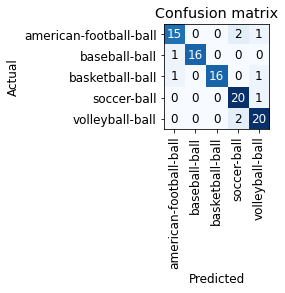

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## levit_128s

O modelo com o menor tempo de processamento por imagem. Tendo como base o `resnet18`, esse modelo não trouxe nenhuma vantagem, pois seu tempo médio foi o mesmo e o seu desempenho foi pior, visto que com o `resnet18` conseguimos chegar em um `error_rate` menor.

/usr/local/lib/python3.8/dist-packages/torch/functional.py:478: UserWarning:

torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)

Downloading: "https://dl.fbaipublicfiles.com/LeViT/LeViT-128S-96703c44.pth" to /root/.cache/torch/hub/checkpoints/LeViT-128S-96703c44.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.691088,1.258822,0.510417,00:32


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



epoch,train_loss,valid_loss,error_rate,time
0,1.787008,0.954907,0.427083,00:32
1,1.572568,0.724835,0.302083,00:32
2,1.307775,0.831906,0.281250,00:34


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



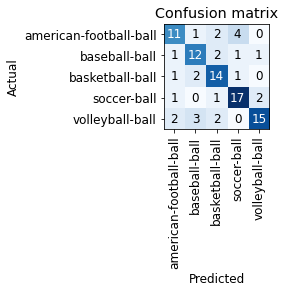

In [12]:
learn = vision_learner(dls, 'levit_128s', metrics=error_rate).to_fp16()
learn.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## regnetx_002

O modelo com menor precisão e o segundo com menor tempo de processamento por imagem. Apesar de ter se saido melhor que o `levit_128s`, também ficou se saiu mal ao tentar chegar em um nivel menor de `error_rate`.

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-regnet/regnetx_002-e7e85e5c.pth" to /root/.cache/torch/hub/checkpoints/regnetx_002-e7e85e5c.pth


epoch,train_loss,valid_loss,error_rate,time
0,2.236850,0.575777,0.177083,00:32


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



epoch,train_loss,valid_loss,error_rate,time
0,0.595715,0.515589,0.166667,00:32
1,0.450178,0.470486,0.156250,00:32
2,0.371829,0.434634,0.145833,00:32


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



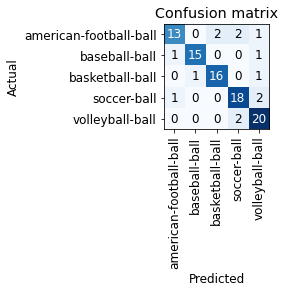

In [13]:
learn = vision_learner(dls, 'regnetx_002', metrics=error_rate).to_fp16()
learn.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## swin_s3_base_224

O modelo com maior precisão e tempo de processamento. Apesar de demorar mais para processar uma imagem, o `swin_s3_base_224` teve um tempo médio praticamente igual ao `resnet18`, porém se saiu muito melhor ao conseguir 4% no `error_rate`. Esse foi o melhor modelo dentre os testados nesse artigo.

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/s3_b-a1e95db4.pth" to /root/.cache/torch/hub/checkpoints/s3_b-a1e95db4.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.165240,0.224549,0.041667,00:35


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



epoch,train_loss,valid_loss,error_rate,time
0,0.281444,0.162254,0.031250,00:35
1,0.221895,0.158361,0.041667,00:38
2,0.168205,0.146433,0.041667,00:36


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



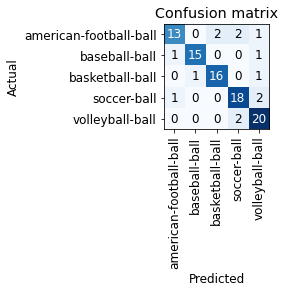

In [14]:
learn_swin = vision_learner(dls, 'swin_s3_base_224', metrics=error_rate).to_fp16()
learn_swin.fine_tune(3)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## convnext_base

O segundo modelo com maior precisão. O seu desempenho correu junto ao esperado, pois dentro dos modelos analizados foi o que alcançou um desempenho semelhante ao `swin_s3_base_224`.

In [15]:
learn = vision_learner(dls, 'convnext_base', metrics=error_rate).to_fp16()
learn.fine_tune(3)

Downloading: "https://dl.fbaipublicfiles.com/convnext/convnext_base_1k_224_ema.pth" to /root/.cache/torch/hub/checkpoints/convnext_base_1k_224_ema.pth


epoch,train_loss,valid_loss,error_rate,time
0,1.210022,0.267617,0.031250,00:35


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



epoch,train_loss,valid_loss,error_rate,time
0,0.235584,0.178642,0.041667,00:38
1,0.174860,0.129516,0.041667,00:35
2,0.132253,0.133928,0.041667,00:36


/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning:

Palette images with Transparency expressed in bytes should be converted to RGBA images



# Resultado

Dentro dos resultados apresentados pelo conjunto de modelos testados nesse artigo, o `swin_s3_base_224` foi o que obteve o melhor resultado em relação ao `error_rate` e por isso será utilizado no deploy. A surpresa do experimento foi todos os modelos demorarem praticamente a mesma quantidade de tempo para executar tudo.

# Deploy

O modelo pode ser executado no link:

